# Thrombolysis prediction shap

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import shap

from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

## Load data

In [2]:
data = pd.read_csv('../data/thrombolysis_xgb_data_2017_2019.csv')

## Split data into X and y

In [3]:
X = data.drop(['thrombolysis'], axis=1)
y = data['thrombolysis']

## Fit XGBoost model

In [4]:
# One hot encode hospitals
X_train_hosp = (pd.get_dummies(X['stroke team'], prefix='team'))
X_train = pd.concat([X, X_train_hosp], axis=1)
X_train.drop('stroke team', axis=1, inplace=True)

# Create XGBoost model
model = XGBClassifier(verbosity=0, seed=42, learning_rate=0.5)
model.fit(X_train, y)

# Save model
pickle.dump(
    model, open('./output/thrombolysis_xgb_model_2017_2019.pkl', 'wb'))

# Get predictions
y_pred = model.predict(X_train)
y_pred_proba = model.predict_proba(X_train)[:, 1]
accuracy = np.mean(y_pred == y)
print(f'\nAccuracy: {accuracy:.3f}')



Accuracy: 0.886


## Get SHAP values

In [5]:
# Set up explainer using the model and feature values from training set
explainer = shap.TreeExplainer(model, X_train)

# GetShapley values along with base and feature values
shap_values_extended = explainer(X_train)
shap_values = shap_values_extended.values

# Save Explainer
pickle.dump(
    explainer, open('./output/thrombolysis_xgb_explainer_2017_2019.pkl', 'wb'))

# Save Shapley values
pickle.dump(
    shap_values, open('./output/thrombolysis_xgb_shap_values_2017_2019.pkl', 'wb'))

100%|===================| 69370/69510 [01:39<00:00]        

## Summary SHAP plot

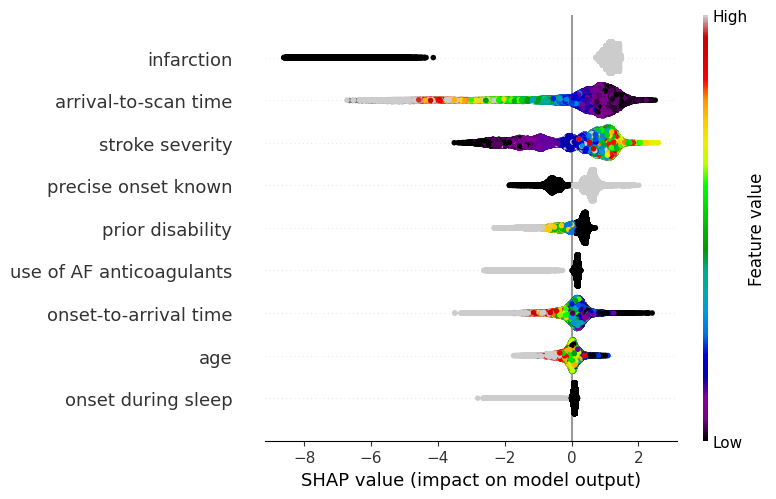

In [6]:
shap.summary_plot(
    shap_values=shap_values,
    features=X_train,
    max_display=9,
    cmap=plt.get_cmap('nipy_spectral'), show=False)


## Get hospital SHAP

In [7]:
# Get list of stroke teams
stroke_teams = X['stroke team'].unique()
stroke_teams.sort()

# Get mean SHAP for stroke team when patient attending that stroke team
stroke_team_mean_shap = dict()
# Loop through stroke teams
for stroke_team in stroke_teams:
    # Identify rows in test data that match each stroke team
    mask = X['stroke team'] == stroke_team
    stroke_team_shap_all_features = shap_values[mask]
    # Get column index for stroke_team_in_shap
    feature_name = 'team_' + stroke_team
    index = list(X_train).index(feature_name)
    # Get SHAP values for hospital
    stroke_team_shap = stroke_team_shap_all_features[:, index]
    # Store median SHAP value for stroke team
    stroke_team_mean_shap[stroke_team] = np.median(stroke_team_shap)

In [8]:
stroke_team_shap_df = pd.DataFrame.from_dict(
    stroke_team_mean_shap, orient='index', columns=['SHAP'])

In [9]:
stroke_team_shap_df

,SHAP
Addenbrooke's Hospital,0.526567
Basildon University Hospital,0.240941
Blackpool Victoria Hospital,-0.353723
Bradford and Airedale SU,-0.235998
Broomfield Hospital,-0.204034
...,...
Worthing Hospital,0.406333
Wycombe General Hospital,0.292859
Yeovil District Hospital,0.392428
York Hospital,-0.247052


Add observed thrombolysis

In [10]:
observed_thrombolysis = data.groupby('stroke team')['thrombolysis'].mean()

In [11]:
stroke_team_shap_df['observed thrombolysis (%)'] = observed_thrombolysis * 100

## Get SHAP main effects

In [12]:
# Get SHAP interaction values
explainer = shap.TreeExplainer(model)
shap_interaction = explainer.shap_interaction_values(X_train)

# Save SHAP interaction values
pickle.dump(
    shap_interaction, open('./output/thrombolysis_xgb_shap_interaction_2017_2019.pkl', 'wb'))

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [13]:
hospital_names = X['stroke team'].unique()
hospital_names.sort()

# Create list of column index for these hospital column titles
hospital_names_ohe = X_train.filter(regex='^team',axis=1).columns
hospital_columns_index = [X_train.columns.get_loc(col) for col in hospital_names_ohe]

hosp_shap_main_effects = []
# Use this index list to access the hosptial shap values (as array)
for i in range(shap_interaction.shape[0]):
    # Get the main effect value for each of the features
    main_effects = np.diagonal(shap_interaction[i])
    hosp_shap_main_effects.append(main_effects[hospital_columns_index])

# Put in dataframe with hospital as column title
df_hosp_shap_main_effects = pd.DataFrame(hosp_shap_main_effects,
                                         columns=hospital_names)

# Include Stroke team that each instance attended
df_hosp_shap_main_effects["stroke team"] = X["stroke team"].values

# Store the sum of the SHAP values (for all of the hospital features)
df_hosp_shap_main_effects["all_stroke_teams"] = (
    df_hosp_shap_main_effects.sum(axis=1))

# Initialise list for 1) SHAP value for attended hospital 2) SHAP value for
#   the sum of the rest of the hospitals
shap_me_attended_hospital = []
shap_me_not_attend_these_hospitals = []

# For each patient
for index, row in df_hosp_shap_main_effects.iterrows():

    # Get stroke team attended
    stroke_team = row["stroke team"]

    # Get SHAP value for the stroke team attended
    shap_me_attended_hospital.append(row[stroke_team])

    # Calculate sum of SHAP values for the stroke teams not attend
    sum_rest = row["all_stroke_teams"] - row[stroke_team]
    shap_me_not_attend_these_hospitals.append(sum_rest)

# Store two new columns in dataframe
df_hosp_shap_main_effects["attended_stroke_team"] = shap_me_attended_hospital
df_hosp_shap_main_effects["not_attended_stroke_teams"] = (
    shap_me_not_attend_these_hospitals)

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


In [14]:
stroke_team_shap_df['SHAP Main Effect'] = (df_hosp_shap_main_effects.groupby(
    ['stroke team'])['attended_stroke_team'].median())

stroke_team_shap_df['Odds Ratio'] = np.exp(stroke_team_shap_df['SHAP Main Effect'])

Plot SHAP

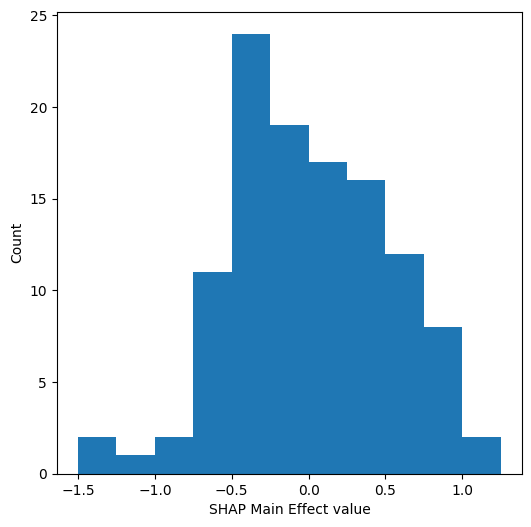

In [15]:
# Plot histogram of shap
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot()
ax.hist(stroke_team_shap_df['SHAP Main Effect'], bins=np.arange(-1.5, 1.31, 0.25))
ax.set_xlabel('SHAP Main Effect value')
ax.set_ylabel('Count')
plt.show()

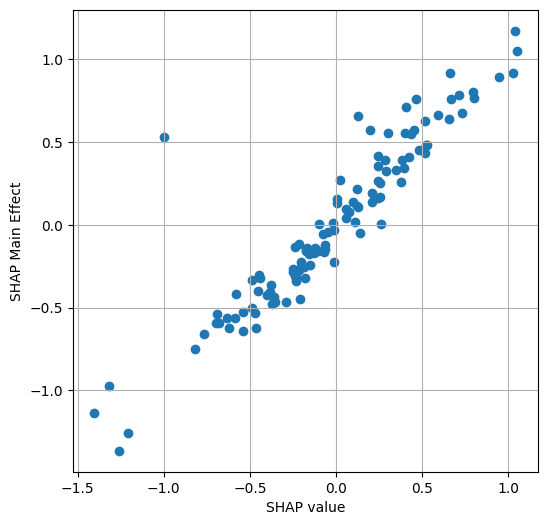

In [16]:
# Plot of scatter plot of shap vs shap main effect
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot()
ax.scatter(stroke_team_shap_df['SHAP'],
           stroke_team_shap_df['SHAP Main Effect'])
ax.set_xlabel('SHAP value')
ax.grid()
ax.set_ylabel('SHAP Main Effect')
plt.show()


## Check thrombolysis rate of a 10k cohort of patients at each hospital

In [17]:
# Stratify by stroke team and thrombolysis
strat = data['stroke team'].map(str) + '-' + data['thrombolysis'].map(str)

In [18]:
# Get training and test data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=10000, stratify=strat, random_state=42)

train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

In [19]:
# One hot encode hospitals
X_train_hosp = (pd.get_dummies(X_train['stroke team'], prefix='team'))
X_train = pd.concat([X_train, X_train_hosp], axis=1)
X_train.drop('stroke team', axis=1, inplace=True)
X_test_hosp = (pd.get_dummies(X_test['stroke team'], prefix='team'))
X_test = pd.concat([X_test, X_test_hosp], axis=1)
X_test.drop('stroke team', axis=1, inplace=True)


In [20]:
# Fit model
model = XGBClassifier(verbosity=0, seed=42, learning_rate=0.5)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.5, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [21]:
# Pass 10k test data through modeel mimicking each hospital

hospitals = list(X['stroke team'].unique())
hospitals.sort()
thrombolysis_rate = []
for hospital in hospitals:

    # Get test data without thrombolysis hospital or stroke team
    X_test_no_hosp = test.drop(['thrombolysis', 'stroke team'], axis=1)

    # Copy hospital dataframe and change hospital ID (after setting all to zero)
    X_test_adjusted_hospital = X_test_hosp.copy()
    X_test_adjusted_hospital.loc[:,:] = 0
    team = "team_" + hospital
    X_test_adjusted_hospital[team] = 1
    
    X_test_adjusted = pd.concat(
        [X_test_no_hosp, X_test_adjusted_hospital], axis=1)
    
    # Get predicted class
    y_pred = model.predict(X_test_adjusted)
    thrombolysis_rate.append(y_pred.mean())

In [22]:
# Add data to summary
stroke_team_shap_df['10K Thrombolysis Rate'] = thrombolysis_rate
stroke_team_shap_df.sort_values(by='SHAP Main Effect', ascending=False, inplace=True)
stroke_team_shap_df = stroke_team_shap_df.round(3)

# Display all rows
pd.options.display.max_rows = 200
stroke_team_shap_df

,SHAP,observed thrombolysis (%),SHAP Main Effect,Odds Ratio,10K Thrombolysis Rate
Morriston Hospital,1.038,41.831,1.173,3.230,0.408
Southend Hospital,1.049,35.674,1.053,2.866,0.401
Watford General Hospital,1.024,37.821,0.920,2.510,0.381
Queen Alexandra Hospital Portsmouth,0.663,33.076,0.919,2.508,0.381
Queens Hospital Romford HASU,0.948,43.380,0.893,2.443,0.387
Luton and Dunstable Hospital,0.798,35.948,0.800,2.225,0.382
Royal Berkshire Hospital,0.715,46.414,0.782,2.187,0.374
Royal London Hospital HASU,0.802,48.807,0.768,2.155,0.349
Charing Cross Hospital HASU,0.665,39.015,0.761,2.140,0.339
West Wales General,0.463,47.753,0.760,2.137,0.367


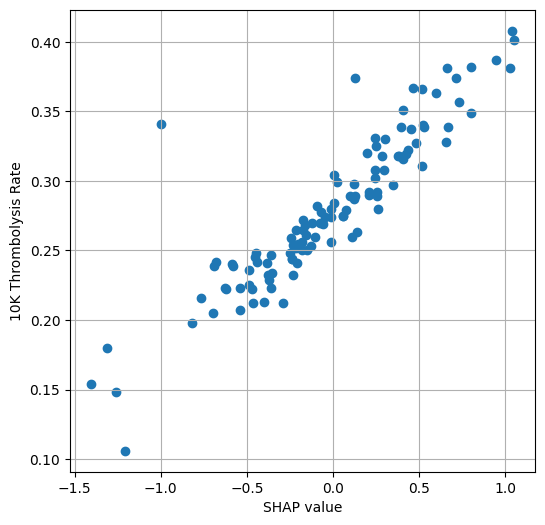

In [23]:
# Plot a scatter plot of SHAP vs 10K Thrombolysis Rate
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot()
ax.scatter(stroke_team_shap_df['SHAP'],
              stroke_team_shap_df['10K Thrombolysis Rate'])
ax.set_xlabel('SHAP value')
ax.grid()
ax.set_ylabel('10K Thrombolysis Rate')
plt.show()

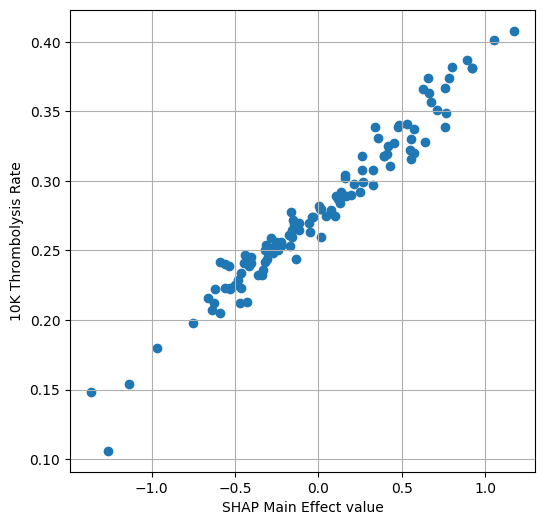

In [24]:
# Plot a scatter plot of main SHAP main effect vs 10K Thrombolysis Rate
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot()
ax.scatter(stroke_team_shap_df['SHAP Main Effect'],
              stroke_team_shap_df['10K Thrombolysis Rate'])
ax.set_xlabel('SHAP Main Effect value')
ax.grid()
ax.set_ylabel('10K Thrombolysis Rate')
plt.show()

## Save results

In [25]:
# Save results
stroke_team_shap_df.to_csv('./output/stroke_team_shap.csv')